In [1]:
import cv2
import numpy as np
from importnb import Notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy.fft as fft
import numpy.matlib
from skimage.transform import rotate
import sys

In [2]:
with Notebook(): 
        import utils
        import pinkNoise

/home/sawar/Documents/dip/project/blind_deblurring/pinkNoise.ipynb:29: RuntimeWarning: divide by zero encountered in reciprocal
  S_f = np.power(np.power(u,2)+np.power(v,2),0.5)**(exponent)


In [3]:
def blurKernel(r, theta):
    kernel = np.zeros((r,r))
    kernel[r//2,:] = 1/r
    return rotateMatrix(kernel, theta)

In [4]:
def blurLegend(directions, magnitude):
    norm = mpl.colors.Normalize(0, np.pi)
    plt.imshow(norm(directions))
    plt.show()

In [5]:
def rotateMatrix(matrix, angle):
#     mat_center = tuple(np.array(matrix.shape[1::-1]) / 2)
#     rot_mat = cv2.getRotationMatrix2D(mat_center, angle, 1.0)
#     return cv2.warpAffine(matrix, rot_mat, matrix.shape[1::-1], flags=cv2.INTER_LINEAR)
    return rotate(matrix, angle)

In [6]:
def MSELoss(img1, img2):
    return np.sum(np.power(img1 - img2, 2))

In [7]:
def linearBlur(img, r, theta):
    kernel = blurKernel(r, theta)
    return cv2.filter2D(np.uint8(img), -1, kernel)

In [8]:
def findKernel(img, r_min=10, r_max=30, inc_ang=5):
    mse = float('inf')
    opt_r, opt_theta = 1, 0
    for r in range(r_min, r_max):
        for theta in range(0, 180, inc_ang):
            blur = linearBlur(img, r, theta)
            err = MSELoss(img, blur)
#             print(r, theta, err, end = '\r')
            if err < mse:
                mse = err
                opt_r, opt_theta = r, theta
    return opt_r, opt_theta

In [9]:
def getImageBlur(img, patch_size = 30):
    blurField = np.zeros(img.shape)
    magnitude = np.zeros(img.shape)
    pd = patch_size // 2
    img = np.pad(img, ((pd, pd), (pd, pd)), 'reflect')
    for i in range(pd, img.shape[0]-pd):
        for j in range(pd, img.shape[1]-pd):
            print(i-pd, j-pd, end = '\r')
            magnitude[i-pd,j-pd], blurField[i-pd,j-pd] = findKernel(img[i-pd:i+pd,j-pd:j+pd], 10, 11, 15)
    return magnitude, blurField

In [10]:
def patches(img):
    rows = img.shape[0]
    cols = img.shape[1]
    patch_size = 30

    for i in range(0, rows, patch_size):
        ex = min(i + patch_size, rows)
        for j in range(img.shape[1]):
            ey = min(j + patch_size, cols)
            print(i,j)
            print(findKernel(img[i:ex, j:ey]))
            

image ./resources/test4.jpg loaded


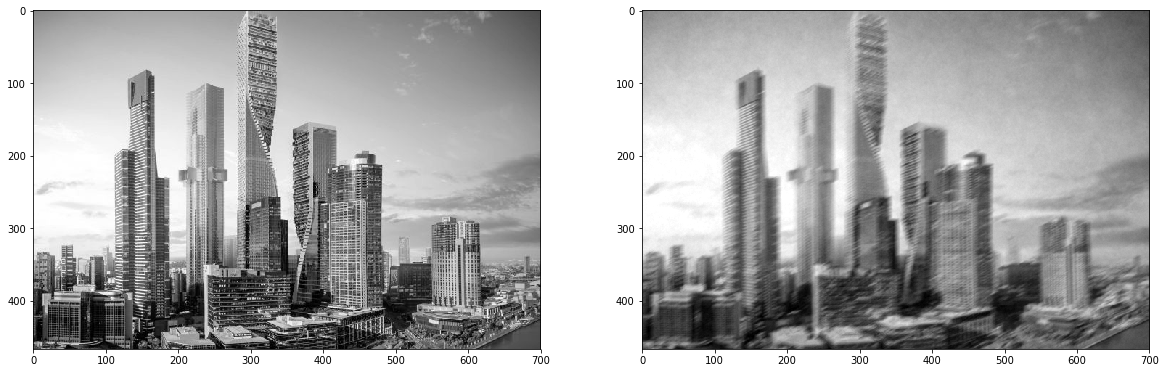

In [17]:
# img = utils.loadImage('./resources/blu.png', 'gray')
img = utils.loadImage('./resources/test4.jpg', 'gray')
blurred_img = linearBlur(img, 10, 30)
blurred_img_noise = pinkNoise.addNoise(blurred_img, -1)
# blurred_img_noise = pinkNoise.addNoise(img, -1)
_, plots = plt.subplots(1,2,figsize=(20,20))
plots[0].imshow(img, cmap = 'gray')
plots[1].imshow(blurred_img_noise, cmap = 'gray')
plt.show()
magnitude, directions = getImageBlur(blurred_img_noise[100:250,200:350], 50)
# print(findKernel(blurred_img_noise[40:80,40:80], 15, 5))
# plt.imshow(ret, cmap = 'gray')


4903 (150, 150)


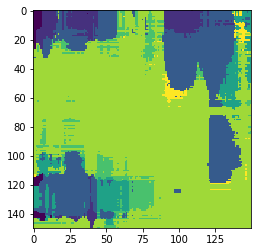

[[ 15.  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.
   30.  30.  30.  30.  30.  30.  30.  15.  30.  15.  15.  15.  30.  15.
   30.  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.
   30.  75.  75.  75.  75.  75.  90.  75.  75.  90.  90.  30.  30.  75.
   90.  90.  90.  90.  90.  90.  75.  75.  75.  75.  75.  75.  75.  90.
   75.  75.  75.  75.  75.  30.  15.  30.  30.  30.  30.  30.  30.  15.
   15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  30.
   30.  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.
   30.  30.  30.  30.  30.  30.  30.  30.]
 [ 15.  30.  90.  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.
   30.  15.  15.  15.  15.  15.  30.  15.  15.  15.  15.  15.  30.  15.
   30.  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.
   30.  75.  75.  75.  75.  75.  75.  75.  75.  90.  90.  90.  90.  75.
   75.  90.  90.  90.  90.  90.  30.  30.  75.  75.  75.  75.  75.  90.
   90.  90.  90.  90.

In [20]:
print(len(np.where(directions == 30)[0]), directions.shape)
blurLegend(directions, magnitude)
np.set_printoptions(threshold=sys.maxsize)
print(directions[15:-15, 15:-15])

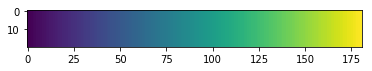

In [13]:
x = np.arange(0, 181)
y = np.arange(0, 20)
X, Y = np.meshgrid(x, y)
blurLegend(X, Y)

In [14]:
fft.fftfreq(10)

array([ 0. ,  0.1,  0.2,  0.3,  0.4, -0.5, -0.4, -0.3, -0.2, -0.1])